# Dissipation in transmon fluxonium system
In this notebook we study dielectric loss in a fluxonium-transmon system

In [60]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
from IPython.display import display, Latex
# from itertools import product, combinations

The gates will be based on the following driven Hamiltonian of capacitively coupled fluxonium and transmon

$$H = H_F + H_T + V$$,

where we have the fluxonium Hamiltonian

$$H_L= 4 E_{C,F} \hat{n}^2_F + \frac{1}{2}E_{L} \hat{\varphi}^2_F - E_{J,F}\cos\left(\hat{\varphi}_F - \varphi_{ext,F}\right), \quad [\hat{\varphi}_F, \hat{n}_F] = i$$,

the transmon Hamiltonian (treated immediately as a Duffing oscillator)

$$H_T =  \hbar \omega_T \hat{b}^{\dagger}\hat{b} + \hbar \frac{\delta_T}{2} \hat{b}^{\dagger} \hat{b}^{\dagger}\hat{b} \hat{b}$$,

where in terms of the transmon's charging energy $E_{C,T}$ and Josephson energy $E_{J, T}$ the transmon's angular velocity $\omega_T$ and anharmonicity $\delta_T$ are

$$ \omega_T = \frac{\sqrt{8 E_{C, T} E_{J, T}}}{\hbar}, \quad \delta_T = - \frac{E_{C,T}}{\hbar} $$.
In addition, the transmon's charge operator can be written as
$$ \hat{n}_T = \frac{i}{2} \biggl( \frac{E_{J, T}}{2 E_{C, T}} \biggr)^{1/4} \bigl( \hat{b}^{\dagger} - \hat{b} \bigr) = \frac{i}{2} \sqrt{\frac{\omega_T}{4 \lvert \delta_T \rvert} }\bigl( \hat{b}^{\dagger} - \hat{b} \bigr).$$

The coupling Hamiltonian is

$$V = J_C  \hat{n}_F \hat{n}_T$$.

# Single fluxonium and transmon

In [61]:
# Values in GHz (divided by h)
#Fluxonium A
ec_f = .973
el_f = .457
ej_f = 8.0 
flux_f = 1/2#pi in the cos
n_fock_f = 100

# Transmon parameters: values in GHz divided by 2 \pi 
omega_t = 4.5 #6.0 
delta_t = -0.3
n_fock_t = 3

In [62]:
levels_f = 5
levels_t = n_fock_t
flx = pysqkit.qubits.Fluxonium('F', ec_f, el_f, ej_f, flux_f, dim_hilbert=n_fock_f)
trans = pysqkit.qubits.SimpleTransmon('T', omega_t, delta_t, dim_hilbert=n_fock_t)
flx.diagonalize_basis(levels_f)

We obtain the energy levels and eigenstates of the two fluxonia

In [63]:
energies_f, eig_states_f = flx.eig_states(levels_f)
energies_t, eig_states_t = trans.eig_states(levels_t)

In [64]:
energies_in_lexico = np.zeros(levels_f*levels_t, dtype=float)
count = 0
for k in range(0, levels_t):
    for m in range(0, levels_f):
        energies_in_lexico[count] = energies_t[k] + energies_f[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

array([ 0,  1,  5,  6,  2,  3, 10, 11,  7,  4,  8, 12, 13,  9, 14])

In [65]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels_f: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels_f: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_f + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

def energy_ascending_order_to_label(
    k : int,
    levels_f: int,
    label_converter : np.ndarray):
    
    lexico_rank = label_converter[k]
    i = lexico_rank//levels_f
    j = lexico_rank%levels_f
    
    return i, j

# Coupled fluxonium and transmon

In [66]:
jc = 0.07 #GHz (divided by h)

coupled_sys = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_sys.eig_states() 

coupled_sys_bare = trans.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_sys_bare.eig_states()

# Jump operators and relaxation rates

In [67]:
temperature = 0.020 # K
en_th = temperature_to_thermalenergy(temperature) # kb T/h in GHz
tan_deltac_f = 7.1*1e-6 
tan_deltac_t = 0.75*1e-6 
qdiel_f = 1/tan_deltac_f
qdiel_t = 1/tan_deltac_t

In [68]:
rel_rate_f, exc_rate_f, gamma_f = flx.dielectric_rates(level_k=0, level_m=1, qdiel=qdiel_f, beta=1/en_th)
rel_rate_t, exc_rate_t, gamma_t = trans.dielectric_rates(level_k=0, level_m=1, qdiel=qdiel_t, beta=1/en_th)
t1_f = 1/(2*np.pi)*1/rel_rate_f/1000 # [mu s]
t1_t = 1/(2*np.pi)*1/rel_rate_t/1000 # [mu s]

In [51]:
display(Latex(r'$T_{{1}}^{{a}} $ = {:.3f} $\mu s$'.format(t1_f)))
display(Latex(r'$T_{{1}}^{{b}} $ = {:.3f} $\mu s$'.format(t1_t)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Notice that these are the relaxation times of the first level of the fluxonium and the transmon respectively.

In [69]:
trans_jumps = trans.dielectric_loss(qdiel_t, 1/en_th, as_qobj=True)
flx_jumps = flx.dielectric_loss(qdiel_f, 1/en_th, as_qobj=True)
jumps = []
for op in trans_jumps:
    jumps.append(qtp.tensor(op, qtp.qeye(levels_f)) )
for op in flx_jumps:
    jumps.append(qtp.tensor(qtp.qeye(levels_t), op) )

### Remark 
The relaxation time of the fluxonium is now very large, keeping the estimated loss tangent fixed as in the Ficheux paper. This is expected since we are now operating at higher $E_J$ and so with a higher barrier. Notice also that now the frequency of the fluxonium is very small

In [70]:
display(Latex(r'$\omega_{{01}}^{{f}}/2 \pi $ = {:.3f} $\mathrm{{GHz}}$'.format(energies_f[1] - energies_f[0])))

<IPython.core.display.Latex object>

This would make the single-qubit gates harder, so maybe it should be increased a bit by increasing $E_L$. Additionally, at the beginning we will use a constant loss tangent. However, that has a dependency with frequency, so we have to be careful when we compare performances with different parameters.

In [71]:
eig_states_by_label = []
energies_by_label = []

for i_a in range(levels_t):
    energies_by_label.append([])
    eig_states_by_label.append([])
    for i_b in range(levels_f):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels_f, eigstates_sys, label_converter), 
                   dims=[[levels_t, levels_f], [1, 1]], shape=[levels_t*levels_f, 1]))
        energies_by_label[i_a].append(label_to_states(i_a, i_b, levels_f, energies_sys, label_converter))

#  Simulations

In [72]:
t_tot = 5000.0

nb_points = 10000
tlist = np.linspace(0, t_tot, nb_points)

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [0,3], [1,3], [2,0]]
labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

hamil0 = coupled_sys.hamiltonian(as_qobj=True)

In [73]:
drive_hamils = []
pulses = []

In [74]:
lev_t, lev_f = 0, 3
statein_label = str(lev_t) + str(lev_f)
state_in = eig_states_by_label[lev_t][lev_f]
output = solvkit.integrate(tlist*2*np.pi, state_in, hamil0, drive_hamils, pulses, jumps, "mesolve")

In [75]:
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j]*eig_states_by_label[i][j].dag())  
        
probs = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, len(labels)):
    i, j = interest_levels[k]
    for m in range(0, nb_points):        
        probs[k, m] = qtp.expect(rhos_by_label[i][j], output.states[m]) 

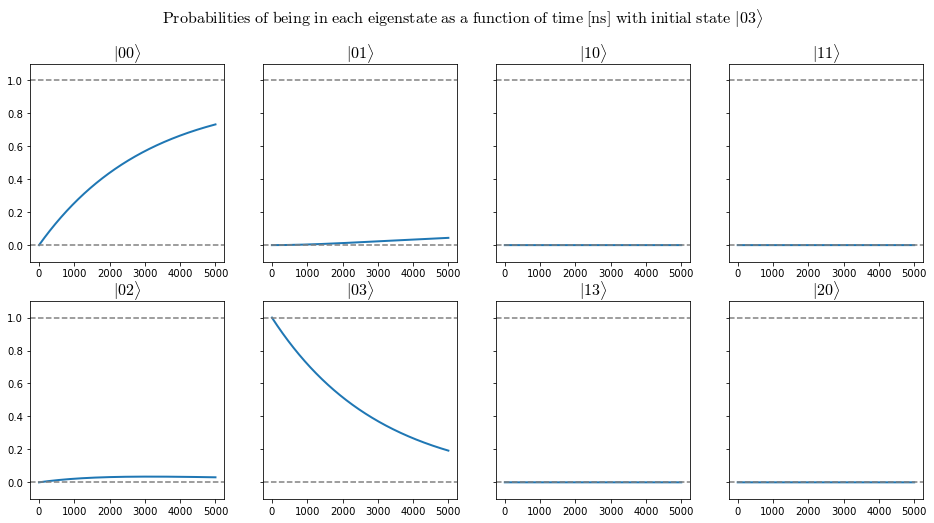

In [76]:
plot_setup = {'lw': 2.0, 'fs': 16, 'fs_text': 14, 'ls': 14}
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray,
    statein_label: str,
    opt: dict
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = (16, 8))
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist, probs[k, :], linewidth=opt['lw'])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k], fontsize=opt['fs'])
        ax[k//4, k%4].set_ylim(-0.1, 1.1)
        ax[k//4, k%4].axhline(y=0, color='grey', linestyle='--')
        ax[k//4, k%4].axhline(y=1, color='grey', linestyle='--')

        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probabilities \ of \ being \ in \ each \ eigenstate \
                 \ as \ a \ function \ of \ time \ [ns] \ with \ initial \ state}$' + 
                 ' $\\vert ' + statein_label + ' \\rangle$', fontsize=opt['fs']) 
    plt.show()

plot_probas(tlist, probs, statein_label, plot_setup)

# Remark
The fact that the fluxonium has worse loss tangents compared to the transmon has clearly a negative effect. Even if the fluxonium is long-lived in the computational subspace this is not true for higher levels, which are transmon like. For instance taking the previous reasonable loss tangents the decay rate of $\lvert 0 3 \rangle$ is $\approx 5 \, \mu s$, while for the transmon is $\approx 50 \, \mu s$. Thus if we use the hiegher levels it is like if we are using a bad transmon.